In [34]:
!pip install python_tsp
!pip install striprtf

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import itertools
import time
from tabulate import tabulate

from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_simulated_annealing
from python_tsp.distances import euclidean_distance_matrix

from striprtf.striprtf import rtf_to_text

In [4]:
# draw points on grid
def draw_grid(points, N, dim, title, filename, save=False):
  fig, ax = plt.subplots()

  ax.set_aspect('equal', adjustable='box')
  ax.plot([points[i][0] for i in range(N)], [points[i][1] for i in range(N)], linestyle='-', color="blue")
  ax.plot([points[0][0], points[N-1][0]], [points[0][1], points[N-1][1]], linestyle='-', color="blue")
  ax.scatter([points[i][0] for i in range(N)], [points[i][1] for i in range(N)],sizes=[220*math.exp(-.05*dim)],color="blue")
  ax.scatter(points[0][0], points[0][1], sizes=[220*math.exp(-.05*dim)], color="yellow", marker='*')

  # gridlines
  lines = np.linspace(-0.5, dim+0.5, dim+2)
  ax.set_xticks(lines, minor=False)
  ax.xaxis.grid(True, which='major')
  ax.set_yticks(lines, minor=False)
  ax.yaxis.grid(True, which='major')
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  ax.set_title(title)
  if save == True: plt.savefig('/content/drive/MyDrive/CBE 449/' + filename)
  plt.show()


# calculate energy for list of N points
def calc_energy(points):
  sum = 0
  for i in range(len(points)-1):
    sum += math.sqrt((points[i][0] - points[i+1][0])**2 + (points[i][1] - points[i+1][1])**2)

  # add distance from point 0 to point N to close loop
  sum += math.sqrt((points[0][0] - points[len(points)-1][0])**2 + (points[0][1] - points[len(points)-1][1])**2)
  return round(sum,4)


# Metropolis acceptance rule for simulated annealing method
def accept(new_energy, old_energy, T):
  del_energy = new_energy - old_energy
  return min(1,math.exp(-1*del_energy/T))


# perturbation function for simulated annealing method
def perturb(points, old_energy, T, n_unchanged):
  # randomly permute points
  new_points = random.sample(points, k=len(points))
  # calculate energy of new permutation
  new_energy = calc_energy(new_points)
  # calculate probability of acceptance
  p_acc = accept(new_energy, old_energy, T)
  # random choice of acceptance from probability distribution
  acc = np.random.binomial(1,p_acc)

  # if success: return new points, reset counter
  if acc == 1:
    n_unchanged = 0
    return new_points, new_energy, n_unchanged
  # otherwise return old points and increment counter
  else:
    n_unchanged += 1
    return points, old_energy, n_unchanged


# simulated annealing method
def sim_anneal(points, energy, T=1000, steps=100, alpha=0.95):
  n_unchanged = 0

  start = time.time()
  i = 0
  # stopping condition: stay in current path 100 perturbations in a row
  while n_unchanged < 100:
    # perturb path and accept or reject perturbation
    points, energy, n_unchanged = perturb(points, energy, T, n_unchanged)

    # reduce T by (1-alpha)% every <steps> steps
    if i % steps == 0: T *= alpha
    i += 1

  end = time.time()
  return round((end-start),4), i, energy, points


# brute force method
def brute_force(points):
  start = time.time()

  # get all possible permutations of N points
  permutations = list(itertools.permutations(points))

  min_energy = math.inf
  optimal_path = []

  # calculate energy of path for all permutations
  for path in permutations:
    curr_energy = calc_energy(path)
    # save energy and path if current optimal
    if curr_energy < min_energy:
      min_energy = curr_energy
      optimal_path = path

  end = time.time()
  return round((end-start),4), min_energy, optimal_path


# python_tsp dynamic programming method
def dynamic_prog(points):
  start = time.time()

  # solve with python_tsp
  distance_matrix = euclidean_distance_matrix(np.array(points))
  path, energy = solve_tsp_dynamic_programming(distance_matrix)
  # convert path output to original points
  points = [points[path[i]] for i in range(len(path))]

  end = time.time()
  return round((end-start),4), round(energy,4), points

Energy of initial path:  19.3178
Initial path:  [[2, 0], [2, 2], [5, 7], [5, 8], [5, 9]]


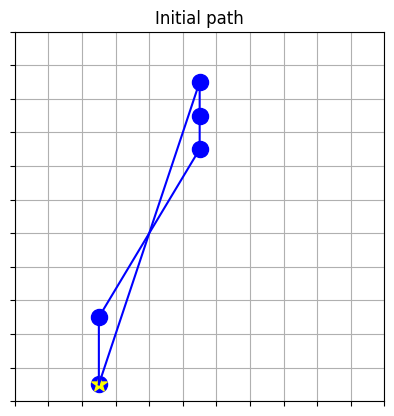

In [8]:
# generate N random points in 2-D and save in (nested) list
N = 5
dim = 10

points = []

# generate random pairs of numbers
while len(points) != N:
  x = random.randint(0,dim-1)
  y = random.randint(0,dim-1)
  if [x,y] not in points: points += [[x,y]]

curr_energy = calc_energy(points)

# Print and draw initial path
print("Energy of initial path: ", curr_energy)
print("Initial path: ", points)
draw_grid(points, N, dim, title="Initial path", save=False, filename='init_100.png')

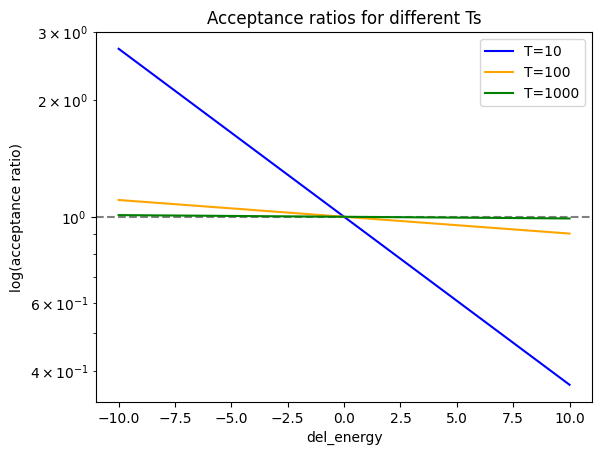

In [5]:
# visualizing T schedule
del_energy = np.linspace(-10,10,100)

T = [10, 100, 1000]

plt.axhline(1, color='gray',linestyle="--")
plt.plot(del_energy, np.exp(-1*del_energy/T[0]), linestyle='-', color='blue',label="T=10")
plt.plot(del_energy, np.exp(-1*del_energy/T[1]), linestyle='-', color='orange',label="T=100")
plt.plot(del_energy, np.exp(-1*del_energy/T[2]), linestyle='-', color='green',label="T=1000")
plt.xlabel("del_energy")
plt.ylabel("log(acceptance ratio)")
plt.yscale('log')
plt.title("Acceptance ratios for different Ts")
plt.legend()
plt.savefig('/content/drive/MyDrive/CBE 449/T_acceptance.png')
plt.show()

In [ ]:
# vary T schedule for simulated annealing
energy_mat = np.zeros((20,5,5))
time_mat = np.zeros((20,5,5))

# 5 trials for each step/alpha pair
for trial in range(5):
  # starting T (chosen from graph) - start by accepting new path >99% of time
  T = 1000

  # number of steps per reduction in T
  steps = np.logspace(.7,3,20)
  # percent reduction in T (T = alpha*T)
  alpha = np.linspace(.9,.99,5)

  min_energy = math.inf
  opt_steps = None
  opt_alpha = None

  for i in range(len(steps)):
    for j in range(len(alpha)):
      sa_time, iter, sa_energy, sa_points = sim_anneal(points, curr_energy, T=1000, steps=int(steps[i]), alpha=alpha[j])
      energy_mat[i,j,trial] = sa_energy
      time_mat[i,j,trial] = sa_time

energy_mat = np.mean(energy_mat,axis=2)
time_mat = np.mean(time_mat,axis=2)

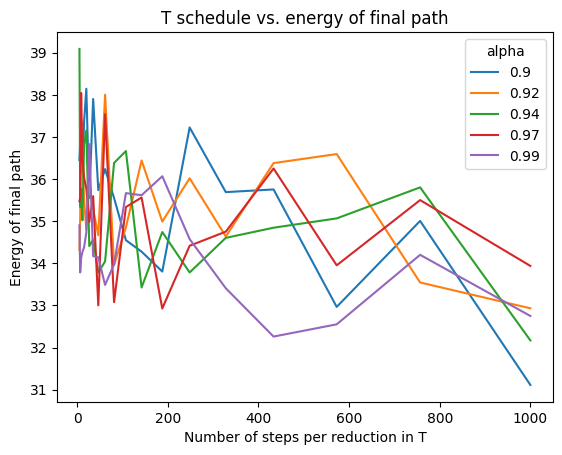

In [ ]:
# Plot results of T schedule experiments
for j in range(len(alpha)):
  plt.plot(steps, energy_mat[:,j], linestyle='-', label=round(alpha[j],2))

plt.xlabel("Number of steps per reduction in T")
plt.ylabel("Energy of final path")
plt.title("T schedule vs. energy of final path")
plt.legend(title="alpha")
plt.savefig('/content/drive/MyDrive/CBE 449/T_sched_energy.png')
plt.show()

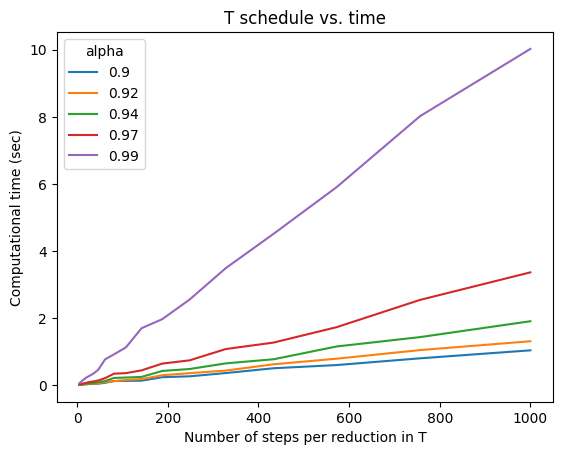

In [ ]:
# Plot cont'd
for j in range(len(alpha)):
  plt.plot(steps, time_mat[:,j], linestyle='-', label=round(alpha[j],2))

plt.xlabel("Number of steps per reduction in T")
plt.ylabel("Computational time (sec)")
plt.title("T schedule vs. time")
plt.legend(title="alpha")
plt.savefig('/content/drive/MyDrive/CBE 449/T_sched_time.png')
plt.show()

+---------------------+--------------+-------------------+------------------+
| Method              |   Time (sec) | Num. iterations   |   Total Distance |
+=====================+==============+===================+==================+
| Brute force         |      0.00076 | N/A               |          19.2315 |
+---------------------+--------------+-------------------+------------------+
| Simulated annealing |      0.4658  | 33530.8           |          19.2315 |
+---------------------+--------------+-------------------+------------------+
| Dynamic programming |      0.0003  | N/A               |          19.2315 |
+---------------------+--------------+-------------------+------------------+


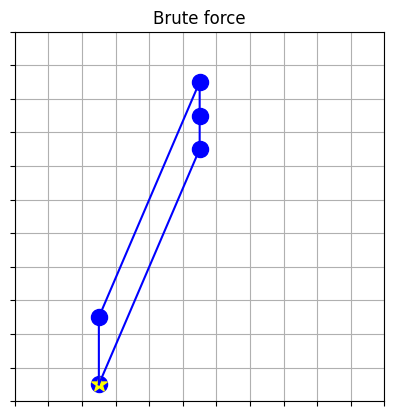

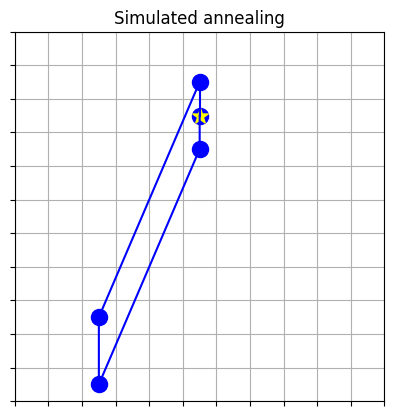

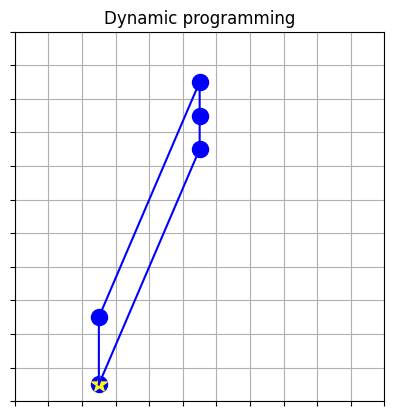

In [9]:
# 3 methods for finding shortest path
incl_bf = True
incl_dp = True

if incl_bf == True:
  bf_times = []
  bf_energies = []

sa_times = []
sa_energies = []
sa_iters = []

if incl_dp == True:
  dp_times = []
  dp_energies = []

# perform experiment 5 times and show average results
for i in range(5):
  # run methods and save results
  if incl_bf == True:
    bf_time, bf_energy, bf_points = brute_force(points)
    bf_times += [bf_time]
    bf_energies += [bf_energy]

  sa_time, sa_iter, sa_energy, sa_points = sim_anneal(points, curr_energy, steps=10*N)
  sa_times += [sa_time]
  sa_energies += [sa_energy]
  sa_iters += [sa_iter]

  if incl_dp == True:
    dp_time, dp_energy, dp_points = dynamic_prog(points)
    dp_times += [dp_time]
    dp_energies += [dp_energy]

# calculate means of results
if incl_bf == True:
  bf_avg_time = np.mean(bf_times)
  bf_avg_energy = np.mean(bf_energies)
else:
  bf_avg_time = "N/A"
  bf_avg_energy = "N/A"

if incl_dp == True:
  dp_avg_time = np.mean(dp_times)
  dp_avg_energy = np.mean(dp_energies)
else:
  dp_avg_time = "N/A"
  dp_avg_energy = "N/A"

sa_avg_time = np.mean(sa_times)
sa_avg_energy = np.mean(sa_energies)
sa_avg_iter = np.mean(sa_iters)


# Print results in table
data = [["Brute force", bf_avg_time, "N/A", bf_avg_energy],
    ["Simulated annealing", sa_avg_time, sa_avg_iter, sa_avg_energy],
    ["Dynamic programming", dp_avg_time, "N/A", dp_avg_energy]]
head = ["Method", "Time (sec)", "Num. iterations", "Total Distance"]
print(tabulate(data, headers=head, tablefmt="grid"))

# Draw results of methods for final points
if incl_bf == True: draw_grid(bf_points, N, dim, title="Brute force", save=False, filename='bf_30.png')
draw_grid(sa_points, N, dim, title="Simulated annealing", save=False, filename='sa_100.png')
if incl_dp == True: draw_grid(dp_points, N, dim, title="Dynamic programming", save=False, filename='dp_30.png')

In [11]:
# energies and times for increasing N (from spreadsheet)
init_Ns = [5, 7, 10, 15, 20, 30, 100]
init_ens = [32.6465, 50.1058, 52.845, 140.2487, 214.8182, 873.6299, 5262.115]

sa_ens = [22.5332, 29.1263, 35.6226, 100.0337, 157.51944, 631.23724, 4539.76302]
sa_times = [1.334, 0.12818, 0.22226, 0.478, 0.66066, 1.44574, 6.2656]

dp_Ns = [5, 7, 10, 15, 20]
dp_ens = [22.5332,28.0637,30.7337,67.7228,79.087]
dp_times = [0.00034,0.00086,0.01236,1.97304,117.4916]

bf_Ns = [5, 7, 10]
bf_ens = [22.5332,28.0637,30.7337]
bf_times = [0.00078,0.03624,43.364]

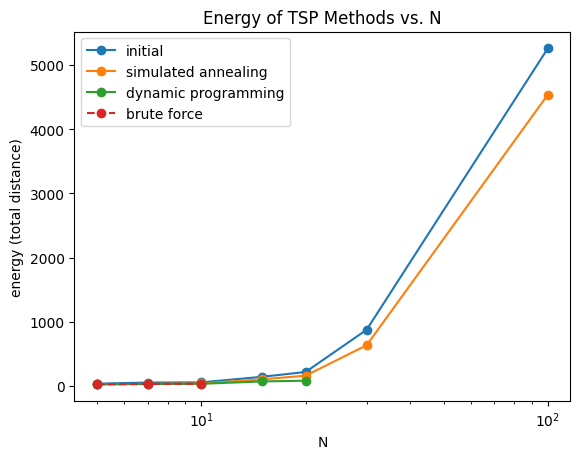

In [31]:
# create energy plot
plt.plot(init_Ns,init_ens,label="initial",linestyle='-',marker='o')
plt.plot(init_Ns,sa_ens,label="simulated annealing",linestyle='-',marker='o')
plt.plot(dp_Ns,dp_ens,label="dynamic programming",linestyle='-',marker='o')
plt.plot(bf_Ns,bf_ens,label="brute force",linestyle='--',marker='o')
plt.xlabel("N")
plt.xscale('log')
plt.ylabel("energy (total distance)")
plt.title("Energy of TSP Methods vs. N")
plt.legend()
plt.savefig('/content/drive/MyDrive/CBE 449/N_energy.png')
plt.show()

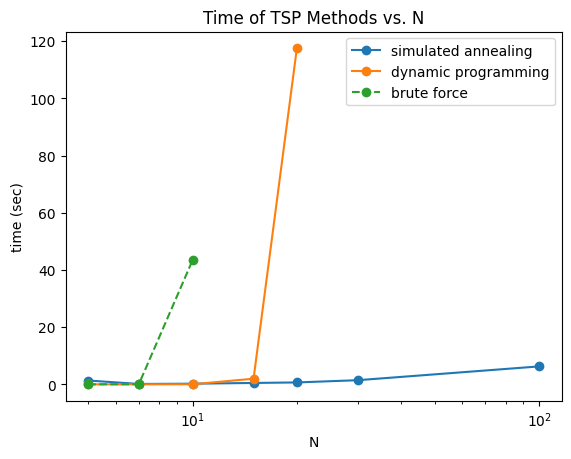

In [32]:
# create energy plot
plt.plot(init_Ns,sa_times,label="simulated annealing",linestyle='-',marker='o')
plt.plot(dp_Ns,dp_times,label="dynamic programming",linestyle='-',marker='o')
plt.plot(bf_Ns,bf_times,label="brute force",linestyle='--',marker='o')
plt.xscale('log')
plt.xlabel("N")
plt.ylabel("time (sec)")
plt.title("Time of TSP Methods vs. N")
plt.legend()
plt.savefig('/content/drive/MyDrive/CBE 449/N_time.png')
plt.show()

In [145]:
# real data from https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html

# read .rtf files
with open('/content/drive/MyDrive/CBE 449/uscap_xy.rtf', 'r') as file:
  caps = file.read()

# remove all white spaces and split into list
caps_text = rtf_to_text(caps)
caps_text = caps_text.replace('   \n   ', '')
caps_text = caps_text.replace('        ', '')
caps_text = caps_text.replace('    ', '')
caps_text = caps_text.replace('  ', ' ')
caps_lines = caps_text.split(' ')
caps_lines = caps_lines[0:100]

# create points list
caps_points = []

for i in range(0, len(caps_lines), 2):
  x = float(caps_lines[i])
  y = float(caps_lines[i+1])
  caps_points += [[x,y]]

caps_curr_energy = calc_energy(caps_points)

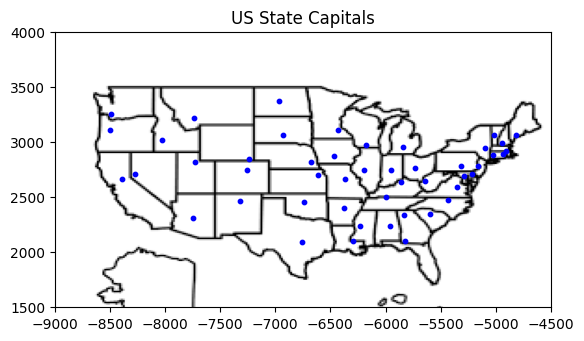

In [144]:
# US Capitals plot
N = len(caps_points)

img = plt.imread('/content/drive/MyDrive/CBE 449/usa_map_flat.png')
plt.imshow(img, extent = (-8750, -4550, 840, 3700))
plt.scatter([caps_points[i][0] for i in range(N)], [caps_points[i][1] for i in range(N)],sizes=[10],color="blue")
plt.xlim((-9000,-4500))
plt.ylim((1500,4000))
plt.title("US State Capitals")
plt.savefig('/content/drive/MyDrive/CBE 449/uscaps.png')
plt.show()

Initial energy:  73253.2525
Final energy:  61765.7679


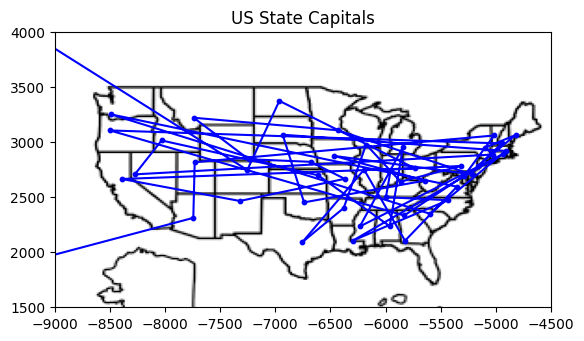

In [148]:
# Simulated annealing for US capitals
_, _, sa_caps_energy, sa_caps_points = sim_anneal(caps_points, caps_curr_energy, steps=1000, alpha=0.99)
print("Initial energy: ", caps_curr_energy)
print("Final energy: ", sa_caps_energy)

img = plt.imread('/content/drive/MyDrive/CBE 449/usa_map_flat.png')
plt.imshow(img, extent = (-8750, -4550, 840, 3700))
plt.plot([sa_caps_points[i][0] for i in range(N)], [sa_caps_points[i][1] for i in range(N)], linestyle='-', color="blue")
plt.plot([sa_caps_points[0][0], sa_caps_points[N-1][0]], [sa_caps_points[0][1], sa_caps_points[N-1][1]], linestyle='-', color="blue")
plt.scatter([sa_caps_points[i][0] for i in range(N)], [sa_caps_points[i][1] for i in range(N)],sizes=[10],color="blue")
plt.xlim((-9000,-4500))
plt.ylim((1500,4000))
plt.title("US State Capitals")
plt.savefig('/content/drive/MyDrive/CBE 449/uscaps_sa.png')
plt.show()